In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential, Model
from IPython.display import display, HTML

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from transformers import TFCamembertModel, CamembertTokenizer, CamembertConfig
# config = CamembertConfig.from_pretrained("camembert-base", output_hidden_states=False)
# camembert = TFCamembertModel.from_pretrained("camembert-base", config=config)
camembert = TFCamembertModel.from_pretrained("camembert-base")
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

from matplotlib import pyplot as plt
TEXT_COLOR = 'white'
BG_COLOR = 'black'
plt.rcParams['axes.facecolor'] = BG_COLOR
plt.rcParams['figure.facecolor'] = BG_COLOR
plt.rcParams['text.color'] = TEXT_COLOR
plt.rcParams['axes.labelcolor'] = TEXT_COLOR
plt.rcParams['xtick.color'] = TEXT_COLOR
plt.rcParams['ytick.color'] = TEXT_COLOR

Some layers from the model checkpoint at camembert-base were not used when initializing TFCamembertModel: ['lm_head']
- This IS expected if you are initializing TFCamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFCamembertModel were not initialized from the model checkpoint at camembert-base and are newly initialized: ['roberta/pooler/dense/bias:0', 'roberta/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:

# TODO :
# faire une base d'evaluation en plus de train et test
# implementer un systeme d'epoch complet avec tf.dataset
# ajouter les données non supervisées au discriminateur => extraction des feature des texte non labelisé à faire
# annulation de la loss du label parametrable (lors de l'utilisation des data non supervisé), faisable en ajoutant des boolean au discriminateur faisant office de mask
# Masking loss : https://stackoverflow.com/questions/64130293/custom-loss-function-in-keras-with-masking-array-as-input

#multi output loss https://datascience.stackexchange.com/questions/86700/custom-loss-function-with-multiple-outputs-in-tensorflow

# https://ledatascientist.com/analyse-de-sentiments-avec-camembert/
# https://ledatascientist.com/introduction-a-la-categorisation-de-textes/
# https://www.kaggle.com/houssemayed/camembert-for-french-tweets-classification
# https://lbourdois.github.io/blog/nlp/BERT/


Definition des models

In [3]:
class CustomCamemBERT(tf.keras.Model):
	def __init__(self, camembert, tokenizer):
		super().__init__()
		self.tokenizer = tokenizer
		self.cam = camembert
		self.GAP = GlobalAveragePooling1D()
		# self.GAP = Flatten()

	def call(self, inputs):
		l = tf.reshape(tf.convert_to_tensor(()), (0, 768 * 1))
		for sentence in inputs:
			# print("\nSentence:", sentence)
			tokenized = tokenizer.tokenize(sentence)
			# print(tokenized)
			encoded = tokenizer.encode(tokenized)
			# print(encoded)
			# print(tokenizer.decode(encoded))
			encoded_sentence = tf.constant([encoded], dtype=tf.int32)
			# print("Sentence encoded:", encoded_sentence.numpy())
			x = self.cam(encoded_sentence).last_hidden_state
			# print(x.shape)
			x = x[:,0,:]
			#x = self.GAP(x)
			# x = tf.reduce_mean(x, axis=1)
			# print("x", x)
			l = tf.concat([l, x], 0)
		# print("l", l)
		return l

# tokenized_sentence = tokenizer.tokenize("J'aime le camembert !")
# encoded_sentence = tf.constant([tokenizer.encode(tokenizer.tokenize("J'aime le camembert !"))], dtype=tf.int32)
# print(encoded_sentence)
# camembert(encoded_sentence)

NLP_model = CustomCamemBERT(camembert, tokenizer)
NLP_model.trainable = False

# display(model("J'aime le camembert !"))
features = NLP_model(["J'adore le camembert", "J'aime le camembert", "J'aime pas le camembert", "Je déteste le camembert"])
# features = NLP_model(["femme", "homme", "roi", "renne"])
# features = features.numpy()
# display(features)
# features.shape
# for i in range(len(features)):
# 	display(np.sqrt(np.sum((features[1] - features[i]) ** 2)))

np.sqrt(np.sum((features[:, np.newaxis, :] - features[np.newaxis, :, :]) ** 2, axis = -1))
# TODO : tester le distance de ces deux vecteurs avec 2 autre "je deteste le camenbert" et "j'adore le camenbert"

array([[0.        , 0.25629252, 0.4085222 , 0.61483765],
       [0.25629252, 0.        , 0.31703305, 0.61425567],
       [0.4085222 , 0.31703305, 0.        , 0.6421592 ],
       [0.61483765, 0.61425567, 0.6421592 , 0.        ]], dtype=float32)

1. Préparation des données et feature extraction

In [4]:
if(os.path.isfile('./featured.csv')):
	sup = np.genfromtxt('featured.csv', delimiter=',')
	print(np.unique(sup[:, :1], return_counts=True))
else:
	sup = pd.read_csv("./supervise.csv")[["text", "label_shufan"]]
	features = NLP_model(sup[["text"]].to_numpy().reshape(-1,).tolist())
	features = features.numpy()
	labels = np.array([sup["label_shufan"]]).T
	sup = np.concatenate([labels, features], axis=1)
	np.savetxt('featured.csv', sup, delimiter=",")

	moresup = pd.read_csv("./newdata.csv")[["text", "Classification"]]
	mapping = {'observation':1, 'information':0, 'hors sujet':0, 'pub':0}
	moresup[["Classification"]] = moresup[["Classification"]].applymap(lambda s: mapping.get(s) if s in mapping else s)
	features = NLP_model(moresup[["text"]].to_numpy().reshape(-1,).tolist())
	features = features.numpy()
	labels = moresup[["Classification"]].values
	moresup = np.concatenate([labels, features], axis=1)

	allsup = np.concatenate([sup, moresup])



(array([0., 1.]), array([566,  71], dtype=int64))


In [5]:
def generate_noise(n_batch, latent_dim):
    return np.random.randn(latent_dim * n_batch).reshape((n_batch, latent_dim))
 
def generate_fake_samples(n_batch, labelN, generator, latent_dim):
	labels = np.repeat(labelN, n_batch)
	X_fake = generator.predict([generate_noise(n_batch, latent_dim), labels])
	y_fake = [labels, np.repeat(0, n_batch)]
	return X_fake, y_fake

def select_real_samples(n_batch, labelN, dataset):
	dataset = dataset[dataset[:, 0] == labelN, :]
	ind = np.random.choice(len(dataset), size=n_batch, replace=False)
	labels = np.repeat(labelN, n_batch)
	X_real = np.array(dataset[ind, 1:].tolist())
	y_real =  [labels, np.repeat(1, n_batch)]
	return X_real, y_real

def train_d(discriminator, dataset, n_batch):
	# (n_batch, 768), ([label, validité])
	X_fake, y_fake = generate_fake_samples(n_batch, 0, generator=G, latent_dim=100)
	d_fake_0 = discriminator.train_on_batch(X_fake, y_fake)

	X_fake, y_fake = generate_fake_samples(n_batch, 1, generator=G, latent_dim=100)
	d_fake_1 = discriminator.train_on_batch(X_fake, y_fake)

	X_real, y_real = select_real_samples(n_batch, 0, dataset=dataset)
	d_real_0 = discriminator.train_on_batch(X_real, y_real)

	X_real, y_real = select_real_samples(n_batch, 1, dataset=dataset)
	d_real_1 = discriminator.train_on_batch(X_real, y_real)

	return (1 / 4) * (d_fake_0[0] + d_fake_1[0] + d_real_0[0] + d_real_1[0])

def train_g(gan, n_batch):
	reality = np.repeat(0, n_batch)
	
	labels = np.repeat(1, n_batch)
	noise = generate_noise(n_batch, latent_dim)
	g_loss_1 = gan.train_on_batch([noise, labels], [labels, reality])

	labels = np.repeat(0, n_batch)
	noise = generate_noise(n_batch, latent_dim)
	g_loss_0 = gan.train_on_batch([noise, labels], [labels, reality])

	return (1 / 2) * (g_loss_1[0] + g_loss_0[0])

In [6]:
sup_train = np.concatenate([sup[sup[:,0] == 1][0:35], sup[sup[:,0] == 0][0:35]])
sup_test  = np.concatenate([sup[sup[:,0] == 1][35:], sup[sup[:,0] == 0][35:]])
sup_test.shape, sup_train.shape
sup_test[:,0]
sup_train[:,0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [7]:
tf.config.run_functions_eagerly(False)
# tf.data.experimental.enable_debug_mode()

def accuracy(out: int = 0, flip: bool = False): 
	""" Genere les fonctions de metriques de precision pour les modèles GAN et D """
	def acc(y_true, y_pred): return tf.keras.metrics.binary_accuracy(y_true, flip - y_pred if flip else y_pred)
	return acc

"""
Cooeficient qui determine l'importance d'une prediction plutot qu'une autre (à traiter comme un meta-parametre)
K pondere l'erreur lié à la prediction de la realité de la donnée
1 - K pondere l'erreur lié à la prediction du label
"""
K = 0.75 # TODO tester ce meta praremetre lorrs des phases d'evaluation
# TODO optimisation if else en dehors de la fonction local
def reality_loss(flip: bool = False, k: float = K): 
	def f(y_true, y_pred):
		# print("reality_loss", '\n',tf.reshape(y_true, (-1,)),'\n', tf.reshape(y_pred, (-1,)))
		return (1 - k) * tf.keras.metrics.binary_crossentropy(y_true, flip - y_pred if flip else y_pred)
	return f

def label_loss(flip: bool = False, k: float = K): 
	def f(y_true, y_pred):
		# print("label_loss",'\n', tf.reshape(y_true, (-1,)),'\n', tf.reshape(y_pred, (-1,)))
		return k * tf.keras.metrics.binary_crossentropy(y_true, flip - y_pred if flip else y_pred)
	return f

def f1_score(precision, recall):
	return 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
	
# @tf.function
# def discriminator_realityloss(y_true, y_pred):
# 	return reality_loss(y_true, y_pred)
# => reality_loss(flip = false)


In [29]:
def generator(latent_dim):
	noise = Input(shape=(latent_dim,), name="noise_input", dtype=tf.float32)
	label = Input(shape=(1,), name="label_input", dtype=tf.float32) 

	label_embedding = Flatten()(Embedding(2, latent_dim, name="label_embeding")(label))
	model_input = Multiply(name="mult_label_noise")([noise, label_embedding])

	x = Dense(128, input_dim=latent_dim)(model_input)
	# x = BatchNormalization()(x)
	x = Dense(256, input_dim=latent_dim)(x)
	# x = BatchNormalization()(x)
	# out = Dense(768, kernel_initializer="random_uniform", name="Generated_Hidden_rep")(x)
	out = Dense(768, kernel_initializer=tf.keras.initializers.RandomNormal(mean=np.mean(sup[:,1:]), stddev=np.std(sup[:,1:]), seed=None), name="Generated_Hidden_rep")(x)
	# out = Dense(768, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None), name="Generated_Hidden_rep")(x)
	return Model([noise, label], out, name="Generator")

def discriminator():
	hidden_rep = Input(shape=(768,), dtype=tf.float32, name="Hidden_rep_Input")
	x = Dense(256)(hidden_rep)
	# x = BatchNormalization()(x)
	x = Dense(256)(hidden_rep)
	# x = BatchNormalization()(x)
	x = Dense(2, activation="tanh")(x)
	# x = tf.keras.layers.ReLU(max_value=1.0, negative_slope=0.0, threshold=0.0)(x)

	Rout = Dense(1, activation="sigmoid", name="Reality")(x)    
	Lout = Dense(1, activation="sigmoid", name="Label")(x)    

	return Model(hidden_rep, [Lout, Rout], name="Discriminator"), Model(hidden_rep, Rout, name="Discriminator") # https://stackoverflow.com/questions/48335212/how-to-prevent-backpropagation-after-compiling-a-keras-model


D, D_ronly = discriminator()
D.compile(loss={"Label":label_loss(), "Reality":reality_loss()}, metrics={"Label":accuracy(flip=False), "Reality":accuracy(flip=False)}, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# D_ronly.compile(loss=reality_loss(flip = False), optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))
D.trainable = False

latent_dim = 100
G = generator(latent_dim)
G.compile()

noise = Input(shape=(latent_dim,), name="GAN_input_noise")
label = Input(shape=(1,), name="GAN_input_label")
hidden_rep = G([noise, label])
validity = D(hidden_rep)
out0 = Lambda(lambda x: x, name="Label")(validity[0]) # juste pour le renomage des layers (sinon nom par defaut {Discriminator, Discriminator_1} bug tf ?)
out1 = Lambda(lambda x: x, name="Reality")(validity[1])

GAN = Model(inputs=[noise, label], outputs=[out0, out1], name="GAN")

# cooperatif ou competition : 
competition = True
GAN.compile(
	loss = {"Label": label_loss(flip = competition), "Reality": reality_loss(flip = True)},
	metrics = {"Label": accuracy(flip = competition), "Reality": accuracy(flip = True)},
	optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

extractor = tf.keras.Model(inputs=D.inputs, outputs=D.layers[-3].output)
extractor.trainable = False
predictor = tf.keras.Model(inputs=extractor.output, outputs=D.output)
predictor.trainable = False

hist = []

# TEST possiblit" de recuperer le poids et le biai lié à chaque dernier noeud pour colorier au dessus/dessous de la fonction affine 

In [9]:
# n_batch = 38
# X_real0, y_real0 = select_real_samples(n_batch, 1, dataset=sup)
# X_real1, y_real1 = select_real_samples(n_batch, 0, dataset=sup)
# X_real = np.concatenate([X_real0, X_real1])
# y_real = np.concatenate([y_real0, y_real1], axis=1).T
# dloss = D.evaluate(X_real, [y_real[:,0], y_real[:,1]], verbose=1)

# reality = np.repeat(0, n_batch * 2)
# labels = np.repeat(1, n_batch * 2)
# noise = generate_noise(n_batch * 2, latent_dim)
# gloss = GAN.evaluate([noise, labels], [labels, reality])


In [10]:
# tf.keras.utils.plot_model(GAN, "test.png", show_shapes=True, expand_nested=True)
D.summary(), G.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Hidden_rep_Input (InputLayer)  [(None, 768)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 256)          196864      ['Hidden_rep_Input[0][0]']       
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256)         1024        ['dense_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dense_2 (Dense)                (None, 2)            514         ['batch_normalization

(None, None)

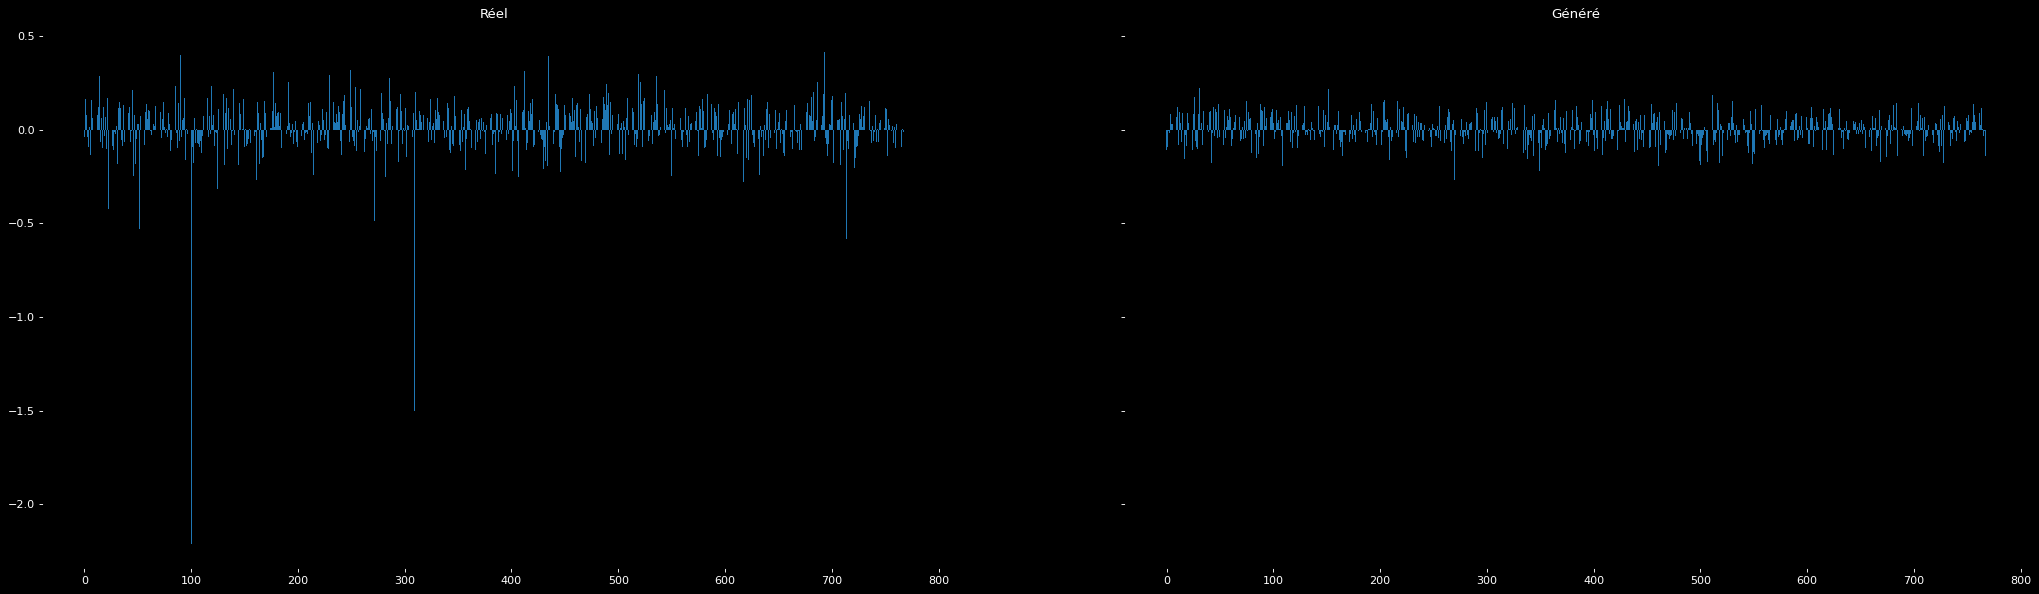

In [30]:
l = np.repeat(1, 1)
n = generate_noise(1, latent_dim)
pred_avant = G.predict([n, l])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16*2, 9), dpi=80)
axs[0].bar(range(768), sup[24,1:])
axs[0].set(title='Réel')
axs[1].bar(range(768), pred_avant[0])
axs[1].set(title='Généré')
plt.show()

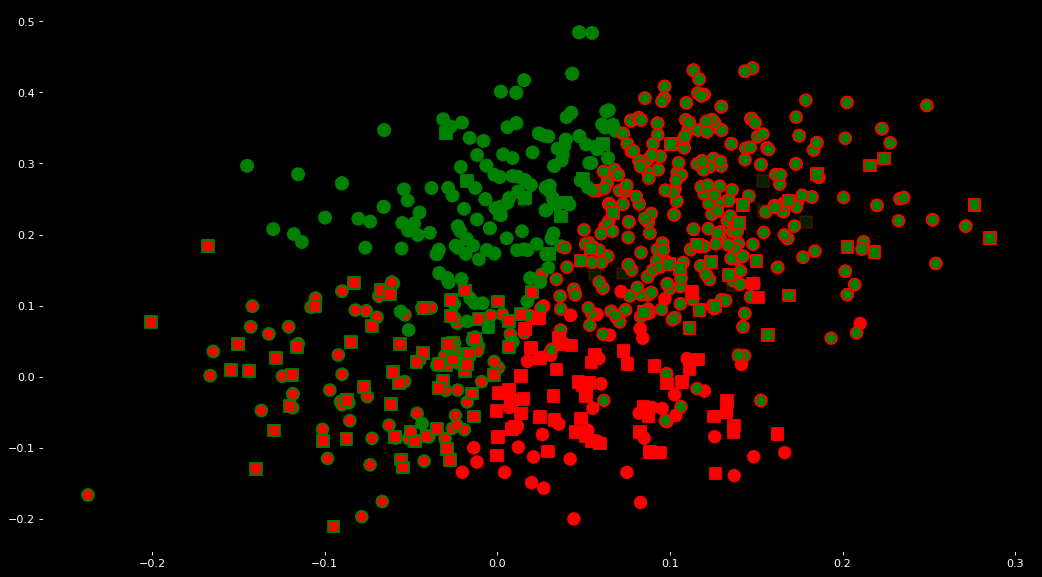

In [31]:
l = np.tile([0, 1], int(244 / 2)).reshape((-1, 1))
n = generate_noise(244, latent_dim)
f2d = np.expand_dims(extractor.predict(G.predict([n, l])), axis=0)
r2d_train = np.expand_dims(extractor.predict(sup_train[:,1:]), axis=0)
r2d_test = np.expand_dims(extractor.predict(sup_test[:,1:]), axis=0)
# add reality
freality = np.repeat(0, np.prod(f2d.shape) / 2).reshape((f2d.shape[0], f2d.shape[1], 1))
train_reality = np.repeat(1, np.prod(r2d_train.shape) / 2).reshape((r2d_train.shape[0], r2d_train.shape[1], 1))
test_reality = np.repeat(1, np.prod(r2d_test.shape) / 2).reshape((r2d_test.shape[0], r2d_test.shape[1], 1))
# add label
flabel = l.reshape((f2d.shape[0], f2d.shape[1], 1))
train_label = sup_train[:,0].reshape((1, sup_train.shape[0], 1))
test_label = sup_test[:,0].reshape((1, sup_test.shape[0], 1))
# add predicction [plabel, preality]
f2d_pred = predictor.predict(f2d[0])
train_pred = predictor.predict(r2d_train[0])
test_pred = predictor.predict(r2d_test[0])
# alpha
fa = np.repeat(1, np.prod(f2d.shape) / 2).reshape((f2d.shape[0], f2d.shape[1], 1))
train_a = np.repeat(0.25, np.prod(r2d_train.shape) / 2).reshape((r2d_train.shape[0], r2d_train.shape[1], 1))
test_a = np.repeat(1, np.prod(r2d_test.shape) / 2).reshape((r2d_test.shape[0], r2d_test.shape[1], 1))
#concatenation
fakes = np.concatenate([f2d, flabel, freality, [f2d_pred[0]], [f2d_pred[1]], fa], axis=-1)
reels_train = np.concatenate([r2d_train, train_label, train_reality, [train_pred[0]], [train_pred[1]], train_a], axis=-1)
reels_test = np.concatenate([r2d_test, test_label, test_reality, [test_pred[0]], [test_pred[1]], test_a], axis=-1)

data = np.concatenate([fakes, reels_train, reels_test], axis=1)
data[0,0].tolist()
# 0 = x
# 1 = y
# 2 = true_label
# 3 = true_reality
# 4 = pred_label
# 5 = pred_reality
# 6 = alpha
plt.figure(figsize=(16, 9), dpi=80)
MapColor = np.array(['r', 'g'])
MapEdgecolor = np.array(['r', 'g'])
MapMarkers = np.array(['o', 's'])
s = 75
es = 125 / s
for _, m in enumerate(np.unique(data[0,:,2])):
	d = data[:,data[0,:,2] == m]
	plt.scatter(d[0,:,0], d[0,:,1], color=MapColor[d[0,:,3].astype(int)], edgecolor=MapEdgecolor[np.round(d[0,:,5]).astype(int)], alpha=d[0,:,6], marker=MapMarkers[int(m)], s=s + s * d[0,:,4], linewidths=es)
# couleur centrale = realité de la donnée (vert = reel, rouge = genere)
# couleur de la bordure = prediction de la réalité de la donnée (vert = reel, rouge = genere)
# carré = observation
# rond = pas une observation

In [32]:
# Pour les labels :
threshold = 0.50

print(np.round(D.predict(sup_test[:,1:])[0].reshape(-1, ), 2))
print(np.where(D.predict(sup_test[:,1:])[0].reshape(-1, ) > threshold, 1, 0))

y_true = sup_test[:,:1].reshape(-1, )
y_pred = D.predict(sup_test[:,1:])[0].reshape(-1, )
y_pred = np.where(y_pred > threshold, 1, 0)

print(np.unique(y_true, return_counts=True))
print(np.unique(y_pred, return_counts=True))
"""
Matrice de confusion | Réalité 0 | Réalité 1 |
		prediction 0 |     VP    |    FP     |
		prediction 1 |     FN    |    VN     |
"""
tf.math.confusion_matrix(y_true, y_pred)

[0.49 0.47 0.5  0.48 0.53 0.48 0.51 0.5  0.53 0.49 0.56 0.52 0.49 0.5
 0.54 0.46 0.53 0.54 0.48 0.49 0.52 0.47 0.52 0.49 0.47 0.47 0.5  0.5
 0.54 0.57 0.48 0.5  0.49 0.54 0.52 0.5  0.49 0.5  0.51 0.53 0.55 0.54
 0.53 0.53 0.51 0.54 0.54 0.54 0.57 0.46 0.51 0.54 0.5  0.49 0.52 0.54
 0.49 0.5  0.54 0.5  0.48 0.47 0.54 0.5  0.54 0.54 0.46 0.54 0.46 0.53
 0.48 0.47 0.5  0.47 0.52 0.48 0.55 0.48 0.49 0.5  0.51 0.51 0.49 0.48
 0.49 0.54 0.51 0.49 0.49 0.48 0.52 0.48 0.5  0.51 0.45 0.54 0.5  0.49
 0.52 0.51 0.58 0.54 0.5  0.5  0.55 0.55 0.55 0.51 0.57 0.58 0.5  0.5
 0.54 0.52 0.47 0.53 0.5  0.52 0.53 0.49 0.47 0.48 0.5  0.51 0.55 0.54
 0.56 0.5  0.51 0.53 0.5  0.46 0.5  0.52 0.52 0.47 0.54 0.48 0.49 0.56
 0.51 0.55 0.5  0.53 0.54 0.5  0.5  0.5  0.51 0.51 0.51 0.48 0.5  0.5
 0.49 0.55 0.48 0.52 0.51 0.56 0.55 0.49 0.51 0.56 0.53 0.48 0.5  0.55
 0.52 0.52 0.52 0.52 0.5  0.5  0.51 0.46 0.53 0.49 0.54 0.53 0.5  0.53
 0.49 0.54 0.54 0.53 0.54 0.46 0.52 0.49 0.5  0.49 0.5  0.5  0.53 0.51
 0.51 0.52

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[141, 390],
       [ 17,  19]])>

In [45]:
epochs = 100
n_batch = 8
glabels = np.concatenate([np.repeat(1, 10), np.repeat(0, 10)])
gnoise = generate_noise(20, latent_dim)
gX = [gnoise, glabels]
gY = glabels.T

X_train = sup_train[:,1:]
labels_train = np.array(sup_train[:,0], dtype=np.float32)
y_train = labels_train

X_test = sup_test[:,1:]
labels_test = np.array(sup_test[:,0], dtype=np.float32)
y_test = labels_test


y_true = sup_test[:,:1].reshape(-1, )


register_every = 1
for e in range(epochs):
	d_loss = train_d(D, sup_train, n_batch)
	g_loss = train_g(GAN, n_batch*1)
	if(e % register_every == 0):

		thresholds = 0.5 # limite pour l'arrondissement

		y_pred_score = D.predict(sup_test[:,1:])[0].reshape(-1, )
		y_pred = np.where(y_pred_score > thresholds, 1, 0)

		precision = tf.keras.metrics.Precision(thresholds=thresholds)(y_true, y_pred).numpy()
		recall = tf.keras.metrics.Recall(thresholds=thresholds)(y_true, y_pred).numpy()
		f1 = f1_score(precision, recall)
		AUC = tf.keras.metrics.AUC()(y_true, y_pred_score).numpy()
		# confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
		# print(f"""
		# Precision: 	{precision}
		# Recall: 	{recall}
		# f1_score: 	{f1}
		# AUC: 		{AUC}
		# Matrice de confusion:\n{confusion_matrix}
		# """)

		"""
		f2d = np.expand_dims(extractor.predict(G.predict([n, l])), axis=0)
		r2d_train = np.expand_dims(extractor.predict(sup_train[:,1:]), axis=0)
		r2d_test = np.expand_dims(extractor.predict(sup_test[:,1:]), axis=0)
		# add predicction [plabel, preality]
		f2d_pred = predictor.predict(f2d[0])
		train_pred = predictor.predict(r2d_train[0])
		test_pred = predictor.predict(r2d_test[0])		
		#concatenation
		fakes = np.concatenate([f2d, flabel, freality, [f2d_pred[0]], [f2d_pred[1]], fa], axis=-1)
		reels_train = np.concatenate([r2d_train, train_label, train_reality, [train_pred[0]], [train_pred[1]], train_a], axis=-1)
		reels_test = np.concatenate([r2d_test, test_label, test_reality, [test_pred[0]], [test_pred[1]], test_a], axis=-1)		
		newdata = np.concatenate([fakes, reels_train, reels_test], axis=1)
		data = np.concatenate([data, newdata], axis=0)
		"""

		hist.append([d_loss, g_loss, precision, recall, f1, AUC])
		print(e, np.round(hist[-1], 2))

# os.system("ffmpeg -r 1 -i ./training/e%01d.png -vcodec mpeg4 -y movie.mp4")


0 [0.53 0.68 0.16 0.81 0.26 0.87]
1 [0.55 0.68 0.16 0.81 0.26 0.87]
2 [0.53 0.68 0.16 0.78 0.27 0.87]
3 [0.53 0.68 0.19 0.78 0.31 0.87]
4 [0.54 0.68 0.2  0.78 0.31 0.87]
5 [0.55 0.68 0.17 0.81 0.28 0.87]
6 [0.54 0.68 0.16 0.81 0.27 0.87]
7 [0.55 0.68 0.19 0.78 0.31 0.88]
8 [0.55 0.68 0.24 0.78 0.37 0.87]
9 [0.52 0.68 0.2  0.78 0.31 0.87]
10 [0.54 0.68 0.16 0.83 0.26 0.87]
11 [0.54 0.68 0.17 0.78 0.27 0.87]
12 [0.52 0.68 0.2  0.78 0.32 0.87]
13 [0.52 0.68 0.2  0.78 0.32 0.86]
14 [0.53 0.68 0.2  0.78 0.31 0.86]
15 [0.52 0.68 0.18 0.78 0.29 0.86]
16 [0.52 0.69 0.17 0.78 0.28 0.86]
17 [0.53 0.69 0.17 0.78 0.28 0.86]
18 [0.52 0.69 0.17 0.78 0.28 0.86]
19 [0.52 0.69 0.17 0.78 0.29 0.86]
20 [0.52 0.69 0.17 0.78 0.28 0.86]
21 [0.52 0.69 0.17 0.78 0.29 0.86]
22 [0.52 0.69 0.18 0.78 0.3  0.86]
23 [0.52 0.69 0.19 0.78 0.3  0.87]
24 [0.51 0.69 0.17 0.78 0.28 0.87]
25 [0.52 0.69 0.17 0.78 0.27 0.87]
26 [0.51 0.69 0.18 0.78 0.29 0.87]
27 [0.52 0.69 0.2  0.78 0.32 0.87]
28 [0.51 0.69 0.2  0.78 0.32 0

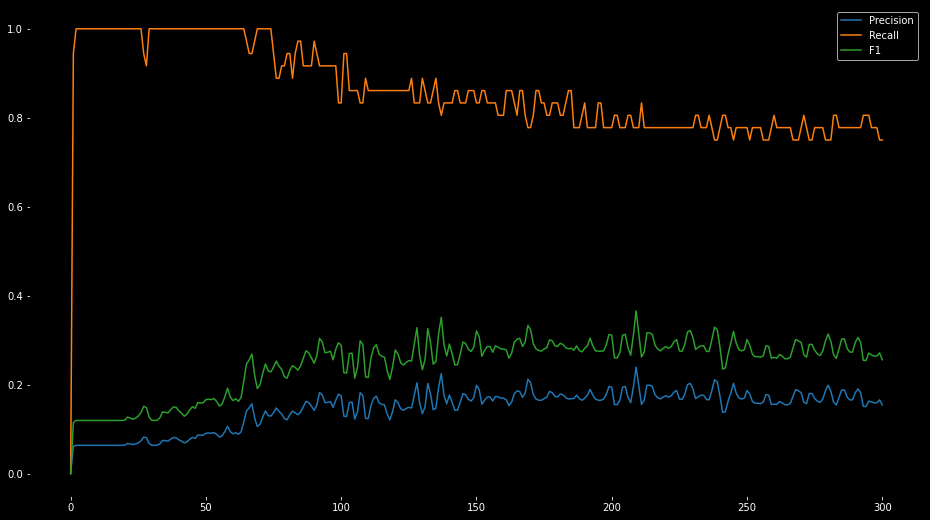

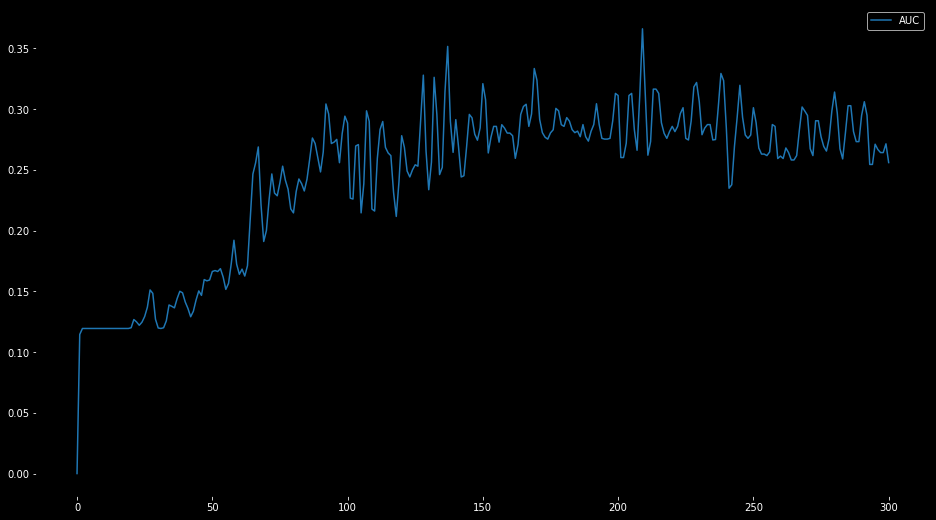

In [46]:
h = np.array(hist)

plt.figure(figsize=(16, 9))
plt.plot(h[:, 2], label="Precision")
plt.plot(h[:, 3], label="Recall")
plt.plot(h[:, 4], label="F1")
plt.legend()
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(h[:, 4], label="AUC")
plt.legend()
plt.show()

In [47]:
thresholds = 0.5 # limite pour l'arrondissement

y_true = sup_test[:,:1].reshape(-1, )
y_pred_score = D.predict(sup_test[:,1:])[0].reshape(-1, )
y_pred = np.where(y_pred_score > thresholds, 1, 0)

print(np.unique(y_true, return_counts=True))
print(np.unique(y_pred, return_counts=True))
"""
Matrice de confusion  | Pred 0 | Pred 1 | Total
			Réalité 0 |   VN   |   FP   | de non observation dans la base
			Réalité 1 |   FN   |   VP   | d'observation dans la base
"""
# https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel

# Precision
# = VP / (VP + FP)
# = VP / P
# = le taux de positif détecté par le modèle (FP étant les individu positif non détecté, VP + FP = l'ensemble des positifs de la base)
# 100% de precision = 0 FP c-a-d que quand le model predit un individu avec la classe 1 on est sur à 100% que l'individu est bien de la classe 1

# Recall = VP / (VP + FN) = taux de bonnes predictions parmis les prediction classé en 1 ?, 100% de recall = aucun FN

# f1 = moyenne harmonique de Precision et Recall

precision = tf.keras.metrics.Precision(thresholds=thresholds)(y_true, y_pred)
recall = tf.keras.metrics.Recall(thresholds=thresholds)(y_true, y_pred)
f1 = f1_score(precision, recall)
AUC = tf.keras.metrics.AUC()(y_true, y_pred_score)
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
print(f"""
Precision: 	{precision}
Recall: 	{recall}
f1_score: 	{f1}
AUC: 		{AUC}
Matrice de confusion:\n{confusion_matrix}
""")

# le but de la confusion_matrix est donc d'avoir sa diagonale avec les valeurs les plus élevé possible

# si notre but est de ne louper aucun messages qui est une observation, on cherche à avoir un recall élevé
# Mais on a des chances d'avoir dans nos predictions beaucoup de messages étant des FP
# exemple avec un modèle "paranoiaque" qui predit tout le temps les message commes étant des observations:
# on a un recall à 100% mais tout les message n'étant pas des observation sont classé comme tel, on a donc une Precision tres faible

# L'entrainement ne suffit pas, une fois fini il faut trouver un thresholds de prediction qui satisfait nos besoins (c-a-d si l'on prefere un fort Recall ou une forte Precision)

(array([0., 1.]), array([531,  36], dtype=int64))
(array([0, 1]), array([392, 175], dtype=int64))

Precision: 	0.1542857140302658
Recall: 	0.75
f1_score: 	0.25592416524887085
AUC: 		0.8497331142425537
Matrice de confusion:
[[383 148]
 [  9  27]]



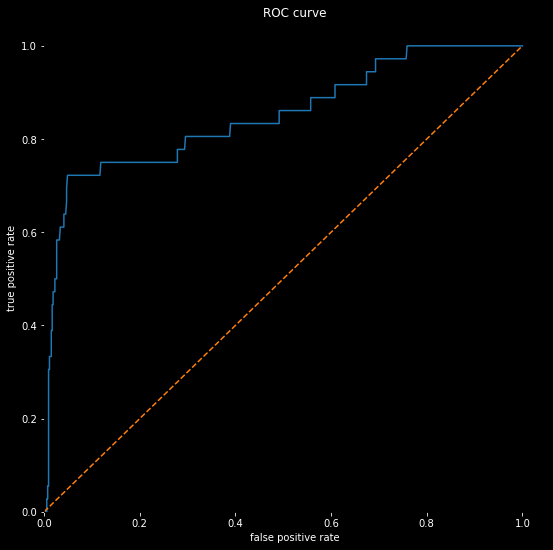

In [48]:
from sklearn.metrics import roc_curve

fpr, tpr, t = roc_curve(y_true, D.predict(sup_test[:,1:])[0].reshape(-1, ))
plt.figure(figsize=(9, 9))
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--", label="")
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

0.4768116173983558 28 [1.8862153  0.8862153  0.88612336 0.88576055 0.88554454 0.8850187
 0.8848107  0.8804065  0.8799922  0.8797064  0.8794255  0.87907094
 0.8789115  0.8784376  0.8783804  0.8783488  0.87727076 0.87691766
 0.87671995 0.8754747  0.87439764 0.8743262  0.87200505 0.86888397
 0.86686575 0.8620306  0.86010325 0.8600755  0.85832024 0.85713285
 0.85651    0.84774494 0.8411573  0.81974936 0.8189402  0.81821656
 0.80236435 0.8017417  0.8003303  0.79523504 0.79453266 0.79265636
 0.79162395 0.7913841  0.76190054 0.7453265  0.74039567 0.7315848
 0.727735   0.7184826  0.6980915  0.6941339  0.6927525  0.689782
 0.6694729  0.6665832  0.63597673 0.63013315 0.62966335 0.5990759
 0.58224076 0.57825977 0.571426   0.56216305 0.5569802  0.5551782
 0.5458153  0.5301384  0.52745706 0.5197223  0.5001178  0.49941447
 0.46697155 0.4632336  0.45678177 0.4430364  0.44070643 0.4204986
 0.39738366 0.39355052 0.37578276 0.36181146 0.35805467 0.35230792
 0.3519775  0.34966612 0.3409441  0.3400979  0.

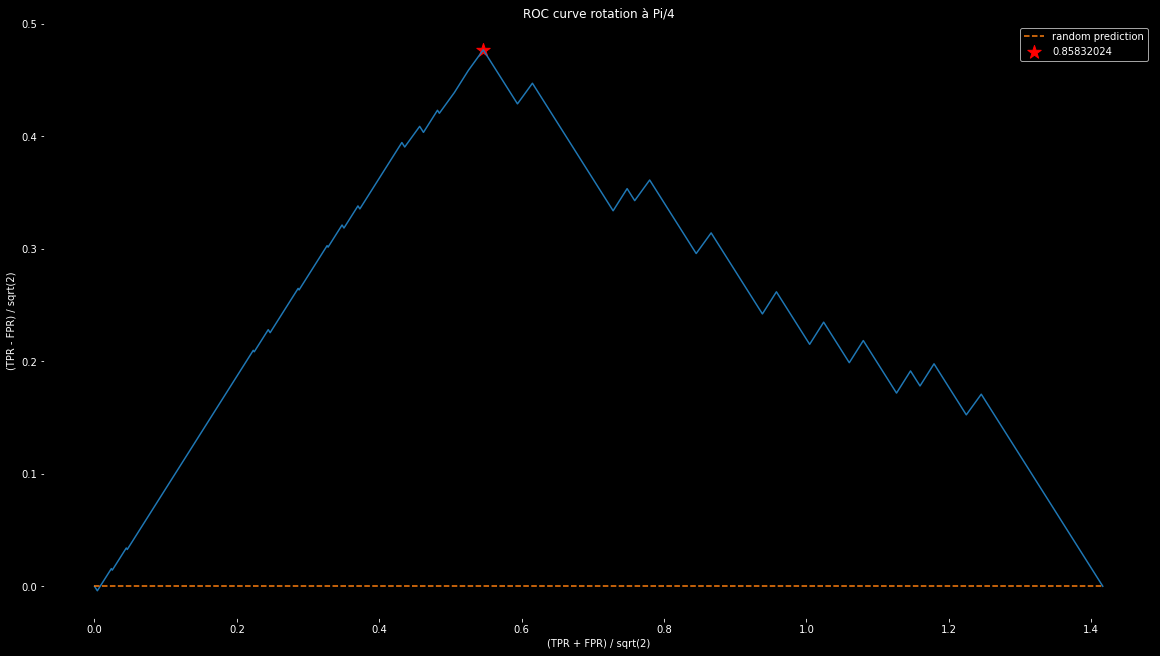

In [49]:
# https://youtu.be/iCZJfO-7C5Q?t=656
plt.figure(constrained_layout=True, figsize=(16, 9))
x = (tpr + fpr) / 1.412
y = (tpr - fpr) / 1.412
plt.plot(x, y)
plt.plot([0, max(x)], [0, 0], ls="--", label="random prediction")
plt.title('ROC curve rotation à Pi/4')
plt.xlabel('(TPR + FPR) / sqrt(2)')
plt.ylabel('(TPR - FPR) / sqrt(2)')
best_t = t[np.argmax(y)]
print(max(y), np.argmax(y), t, best_t)
plt.scatter(x[np.argmax(y)], np.max(y), label=best_t, marker='*', c='red', s=200)
plt.legend()
plt.show()

In [50]:
thresholds = 0.5
y_true = sup_test[:,:1].reshape(-1, )
y_pred_scrore = D.predict(sup_test[:,1:])[0].reshape(-1, )
y_pred = np.where(y_pred_scrore > thresholds, 1, 0)
precision = tf.keras.metrics.Precision(thresholds=thresholds)(y_true, y_pred)
recall = tf.keras.metrics.Recall(thresholds=thresholds)(y_true, y_pred)
f1 = f1_score(precision, recall)
AUC = tf.keras.metrics.AUC()(y_true, y_pred_scrore)
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
print(f"""
Threshold {thresholds}
{np.unique(y_true, return_counts=True)}
{np.unique(y_pred, return_counts=True)}
Precision: 	{precision*100:.2f}%
Recall: 	{recall*100:.2f}%
f1_score: 	{f1*100:.2f}%
AUC: 		{AUC*100:.2f}%
Matrice de confusion:\n{confusion_matrix}
""")

lp, lr, lf = precision, recall, f1

thresholds = best_t
y_true = sup_test[:,:1].reshape(-1, )
y_pred_scrore = D.predict(sup_test[:,1:])[0].reshape(-1, )
y_pred = np.where(y_pred_scrore > thresholds, 1, 0)
precision = tf.keras.metrics.Precision(thresholds=thresholds)(y_true, y_pred)
recall = tf.keras.metrics.Recall(thresholds=thresholds)(y_true, y_pred)
f1 = f1_score(precision, recall)
AUC = tf.keras.metrics.AUC()(y_true, y_pred_scrore)
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
print(f"""
Threshold {thresholds}
{np.unique(y_true, return_counts=True)}
{np.unique(y_pred, return_counts=True)}
Precision: 	{precision*100:.2f}% ({(precision - lp)*100:+.2f}%)
Recall: 	{recall*100:.2f}% ({(recall - lr)*100:+.2f}%)
f1_score: 	{f1*100:.2f}% ({(f1 - lf)*100:+.2f}%)
AUC: 		{AUC*100:.2f}%
Matrice de confusion:\n{confusion_matrix}
""")


Threshold 0.5
(array([0., 1.]), array([531,  36], dtype=int64))
(array([0, 1]), array([392, 175], dtype=int64))
Precision: 	15.43%
Recall: 	75.00%
f1_score: 	25.59%
AUC: 		84.97%
Matrice de confusion:
[[383 148]
 [  9  27]]


Threshold 0.8583202362060547
(array([0., 1.]), array([531,  36], dtype=int64))
(array([0, 1]), array([517,  50], dtype=int64))
Precision: 	50.00% (+34.57%)
Recall: 	69.44% (-5.56%)
f1_score: 	58.14% (+32.55%)
AUC: 		84.97%
Matrice de confusion:
[[506  25]
 [ 11  25]]



In [30]:
from matplotlib import animation
from matplotlib.gridspec import GridSpec
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128


h = np.asarray(hist)

fig = plt.figure(constrained_layout=True, figsize=(16, 9))
gs = GridSpec(4, 4, figure=fig)
ax1, ax2 = fig.add_subplot(gs[0:-1, 1:-1]), fig.add_subplot(gs[-1, :])

def animate(i):
	ax1.clear()
	# ax1.set_xlim([-1., 1.])
	# ax1.set_ylim([-1., 1.])
	for _, m in enumerate(np.unique(data[i,:,2])):
		d = data[:,data[i,:,2] == m]
		ax1.scatter(d[i,:,0], d[i,:,1], color=MapColor[d[i,:,3].astype(int)], edgecolor=MapEdgecolor[np.round(d[i,:,5]).astype(int)], alpha=d[i,:,6], marker=MapMarkers[int(m)], s=s + s * d[i,:,4], linewidths=es)
	ax2.clear()
	ax2.set_xlim([0, h.shape[0]])
	ax2.plot(h[:i,[0, 1]])

ani = animation.FuncAnimation(fig, animate, frames=data.shape[0])
plt.close()
print("render...")
out = HTML(ani.to_jshtml())

out

render...


In [18]:
with open('result_stable.html', 'w') as f:
	print("save...")
	f.write(out.data)

save...


In [274]:
from matplotlib import animation
from matplotlib.gridspec import GridSpec
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128


h = np.asarray(hist)

fig = plt.figure(constrained_layout=True, figsize=(16, 9))
gs = GridSpec(4, 4, figure=fig)
ax1, ax2 = fig.add_subplot(gs[0:-1, 1:-1]), fig.add_subplot(gs[-1, :])

def animate(i):
	ax1.clear()
	ax1.set_xlim([-1.1, 1.1])
	ax1.set_ylim([-1.1, 1.1])
	for _, m in enumerate(np.unique(data[i,:,3])):
		d = data[:,data[i,:,2] == m]
		ax1.scatter(d[i,:,0], d[i,:,1], color=MapColor[d[i,:,2].astype(int)], edgecolor=MapEdgecolor[np.round(d[i,:,4]).astype(int)], alpha=d[i,:,6], marker=MapMarkers[int(m)], s=s + s * d[i,:,5], linewidths=es)
	ax2.clear()
	ax2.set_xlim([0, h.shape[0]])
	ax2.plot(h[:i,[0, 1]])

ani = animation.FuncAnimation(fig, animate, frames=data.shape[0])
plt.close()
print("render...")
out = HTML(ani.to_jshtml())

# with open('result2.html', 'w') as f:
# 	print("save...")
# 	f.write(out.data)

out

render...


In [295]:
from matplotlib import animation
from matplotlib.gridspec import GridSpec
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

# 0 = x
# 1 = y
# 2 = true_label
# 3 = true_reality
# 4 = pred_label
# 5 = pred_reality
# 6 = alpha

h = np.asarray(hist)

fig = plt.figure(constrained_layout=True, figsize=(16, 9))
gs = GridSpec(4, 4, figure=fig)
ax1, ax2 = fig.add_subplot(gs[0:-1, 1:-1]), fig.add_subplot(gs[-1, :])

def animate(i):
	ax1.clear()
	# ax1.set_xlim([-1.1, 1.1])
	# ax1.set_ylim([-1.1, 1.1])
	d = data[:,data[i,:,3] == 1]
	ax1.scatter(d[i,:,0], d[i,:,1], color=MapColor[d[i,:,2].astype(int)], edgecolor=MapEdgecolor[np.round(d[i,:,4]).astype(int)], alpha=d[i,:,6],s=s, linewidths=es)
	ax2.clear()
	ax2.set_xlim([0, h.shape[0]])
	ax2.plot(h[:i,[0, 1]])

ani = animation.FuncAnimation(fig, animate, frames=data.shape[0])
plt.close()
print("render...")
out = HTML(ani.to_jshtml())

out

render...


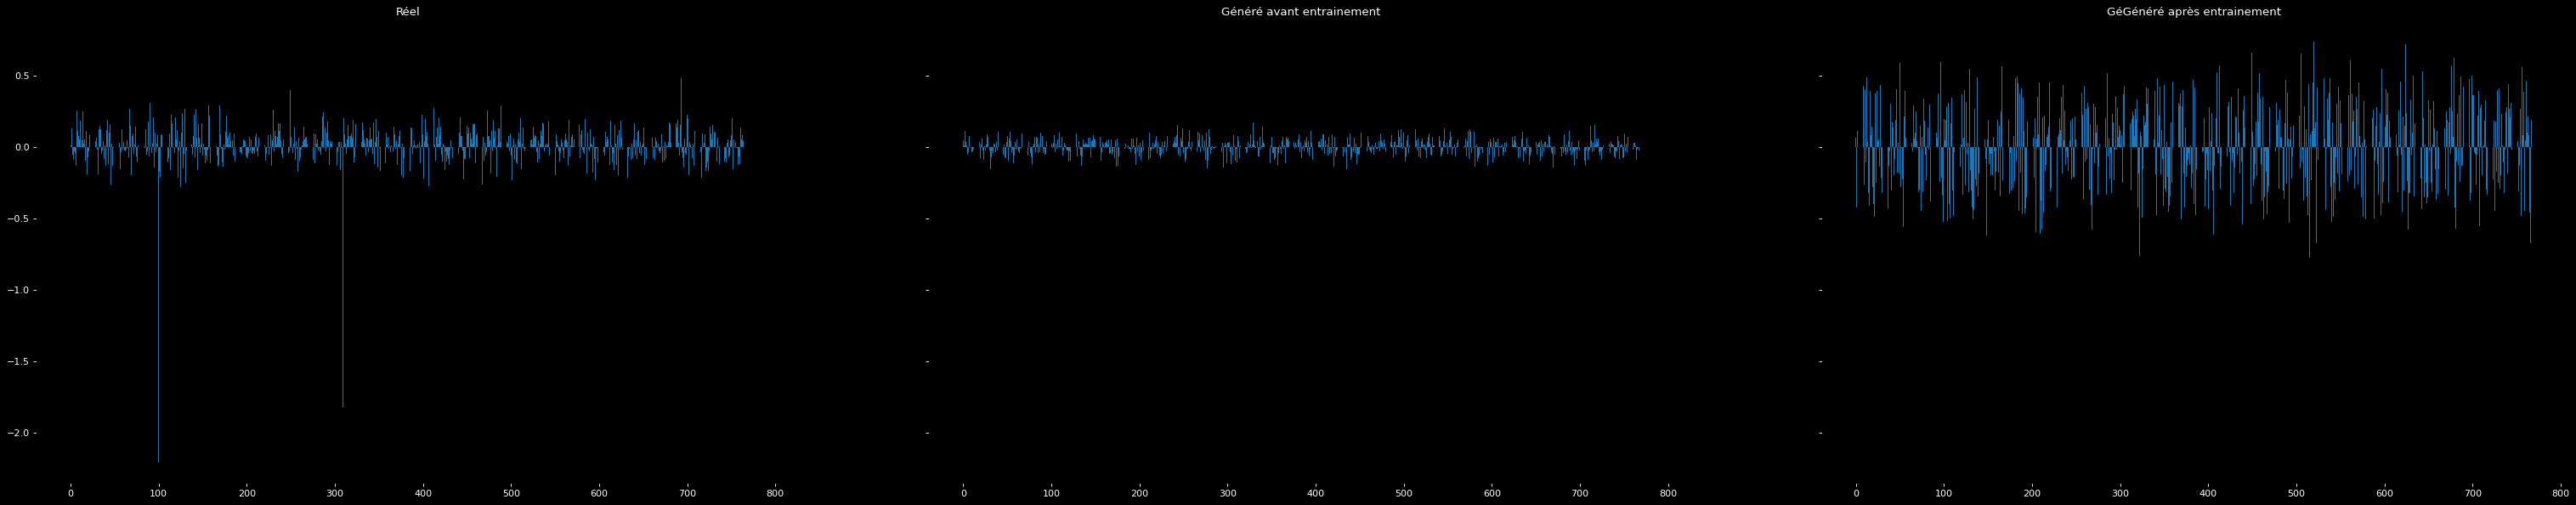

In [66]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16*3, 9), dpi=80)
pred_apres = G.predict([n, l])
axs[0].bar(range(768), sup[20,1:])
axs[0].set(title='Réel')
axs[1].bar(range(768), pred_avant[0])
axs[1].set(title='Généré avant entrainement')
axs[2].bar(range(768), pred_apres[0])
axs[2].set(title='GéGénéré après entrainement')
plt.show()

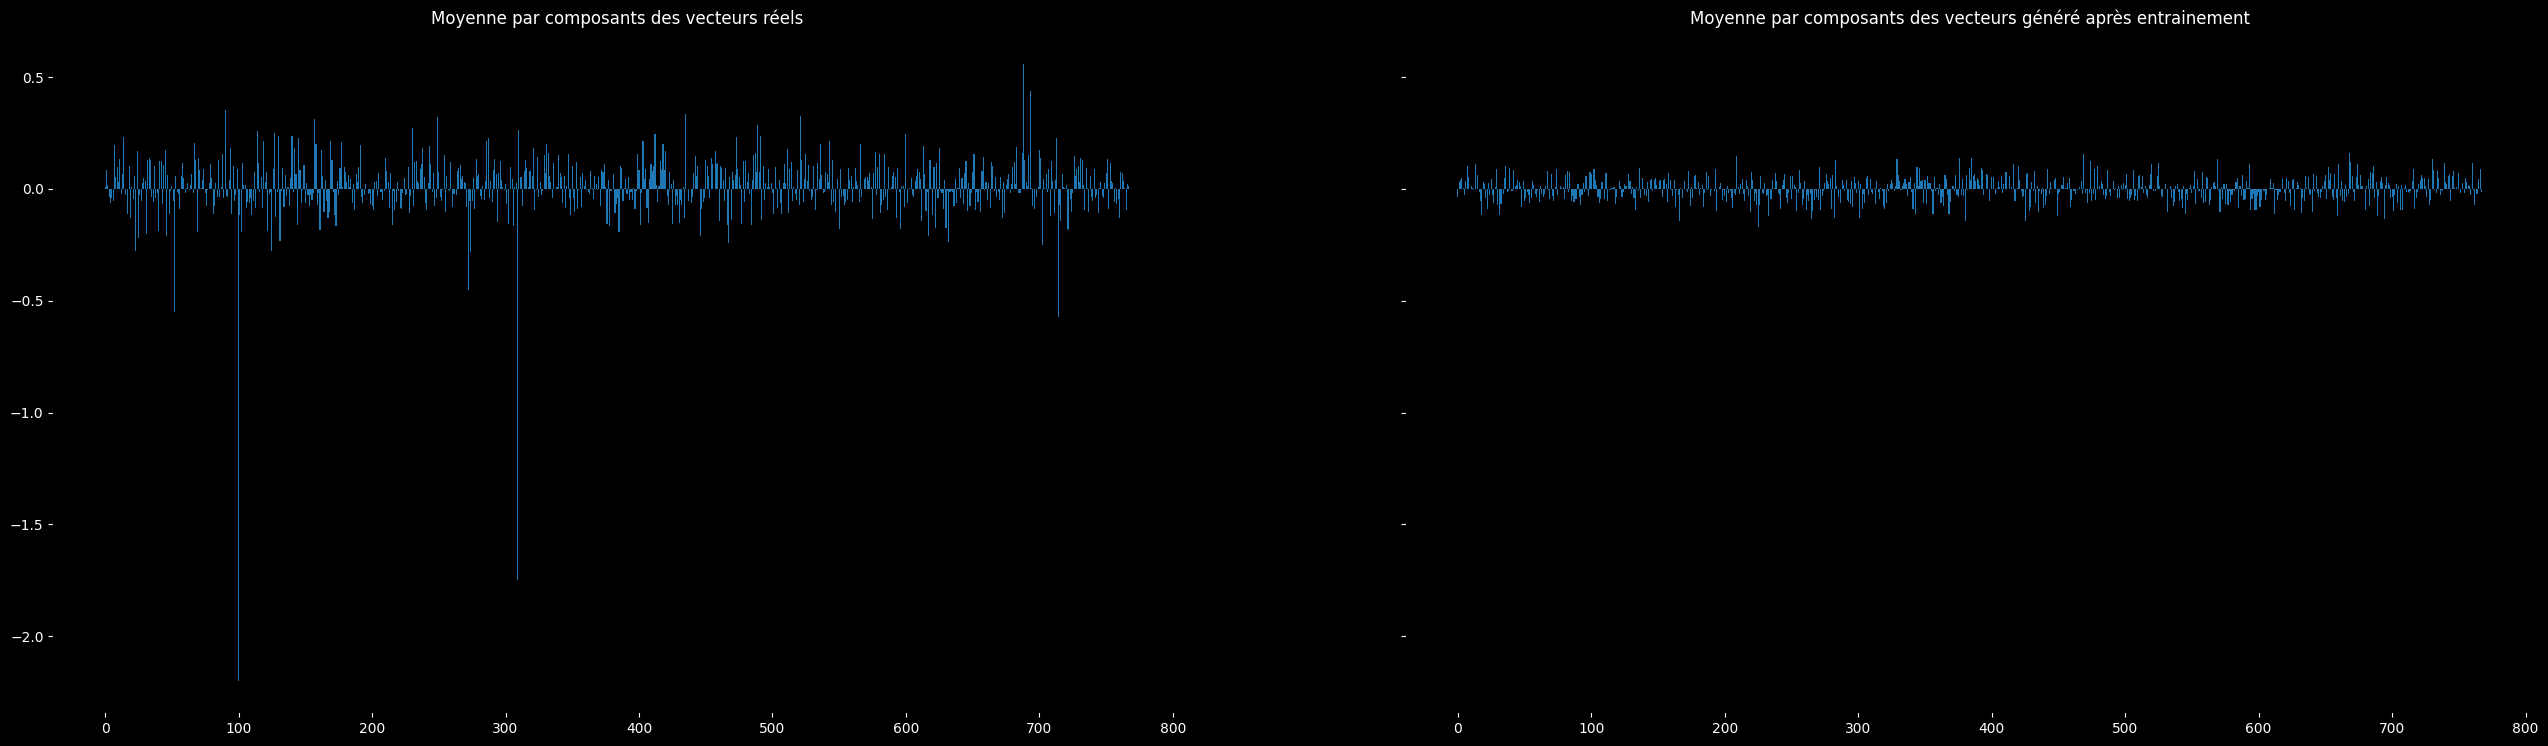

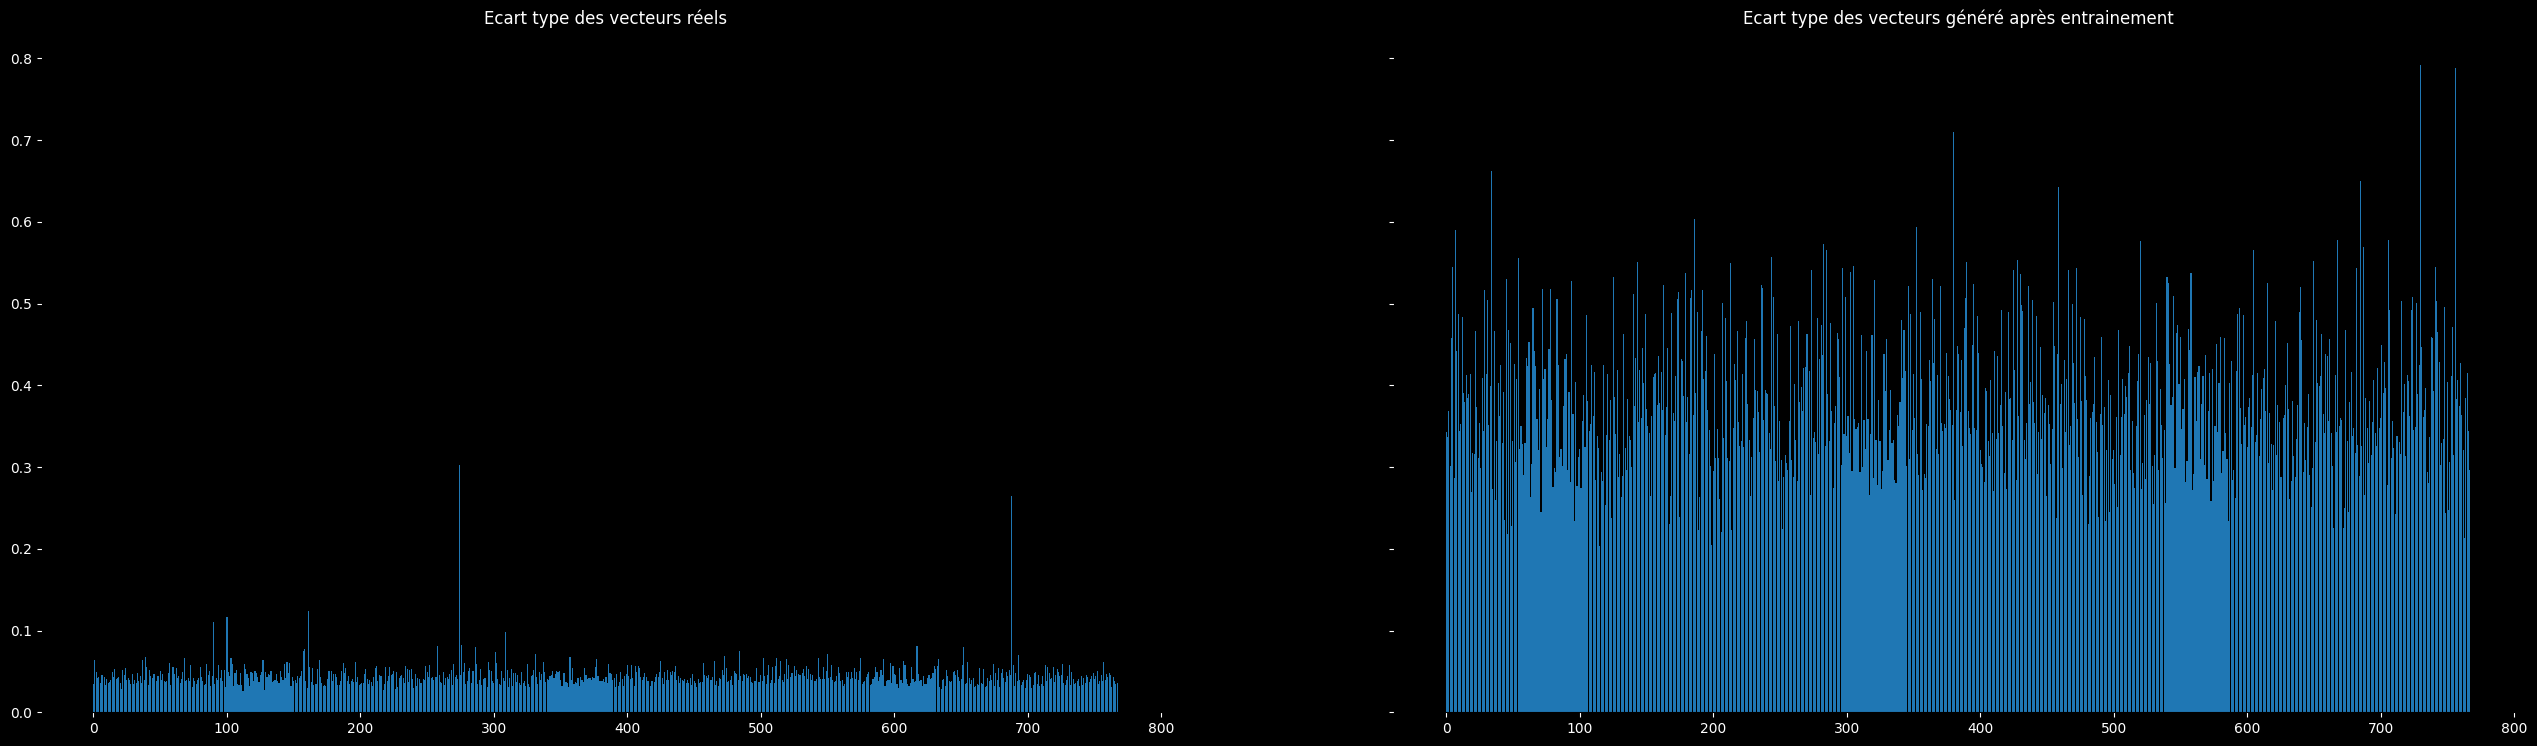

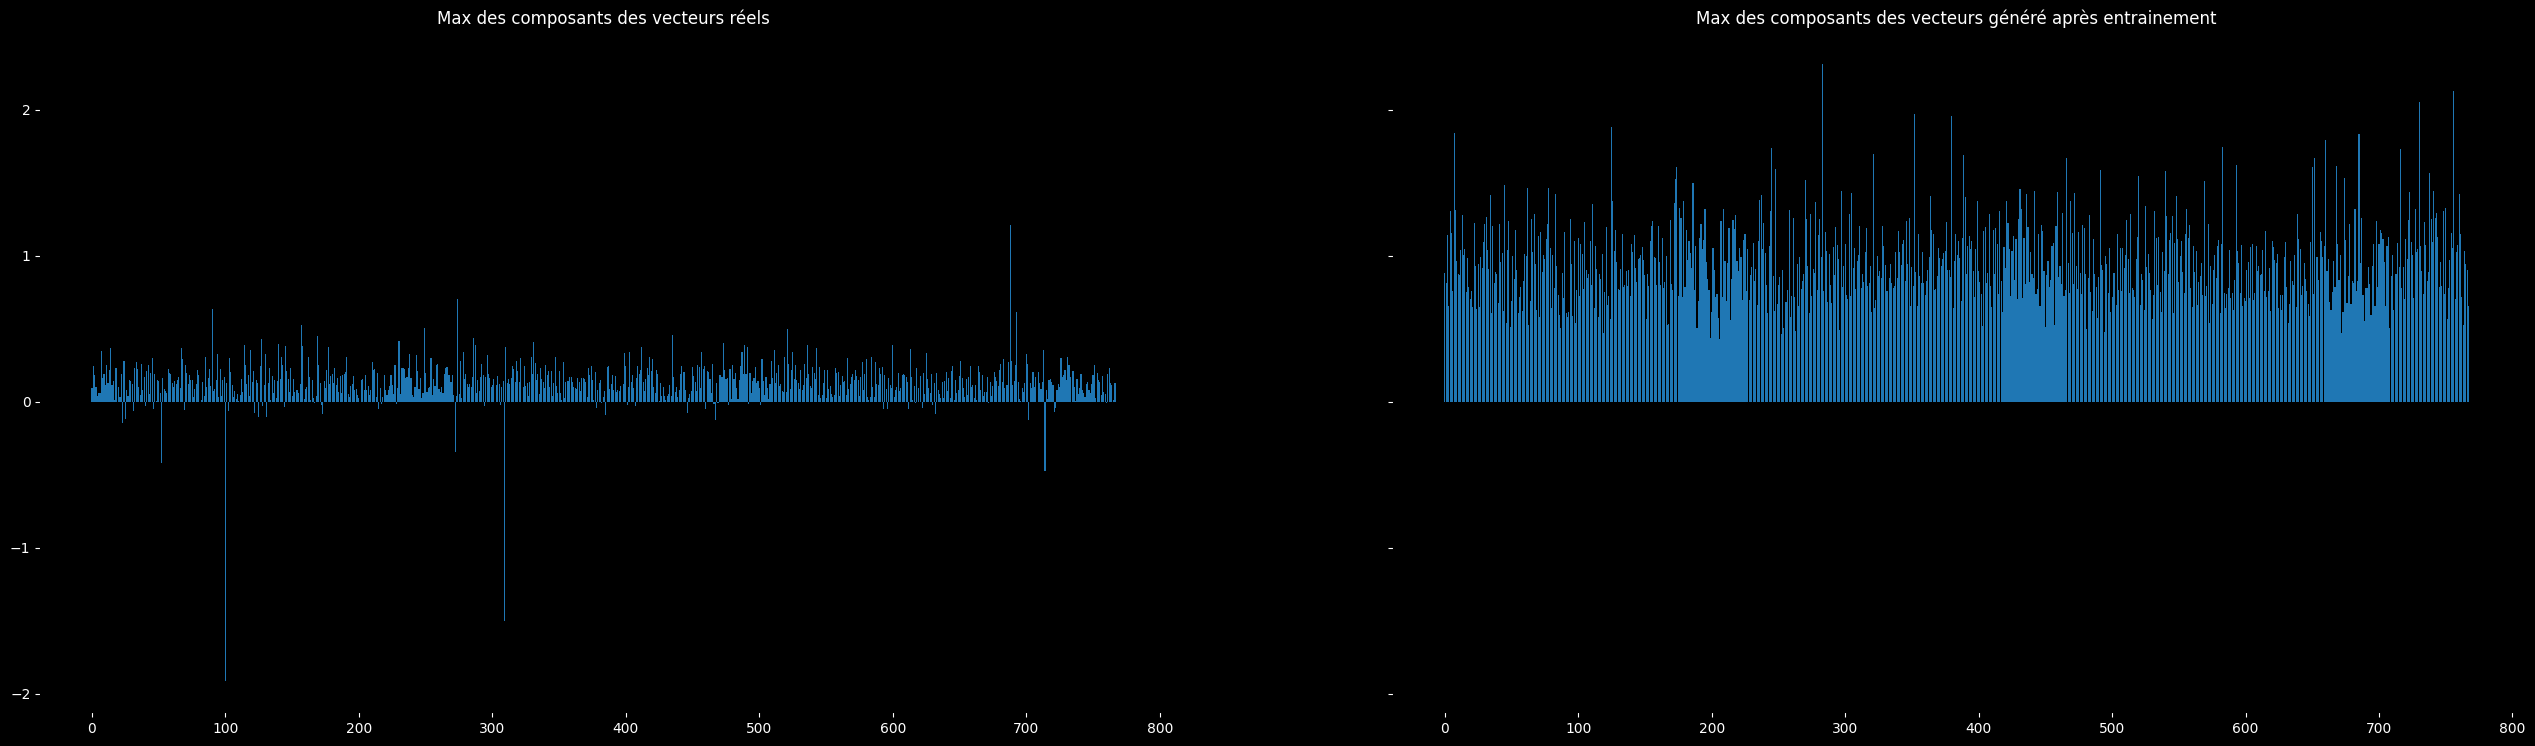

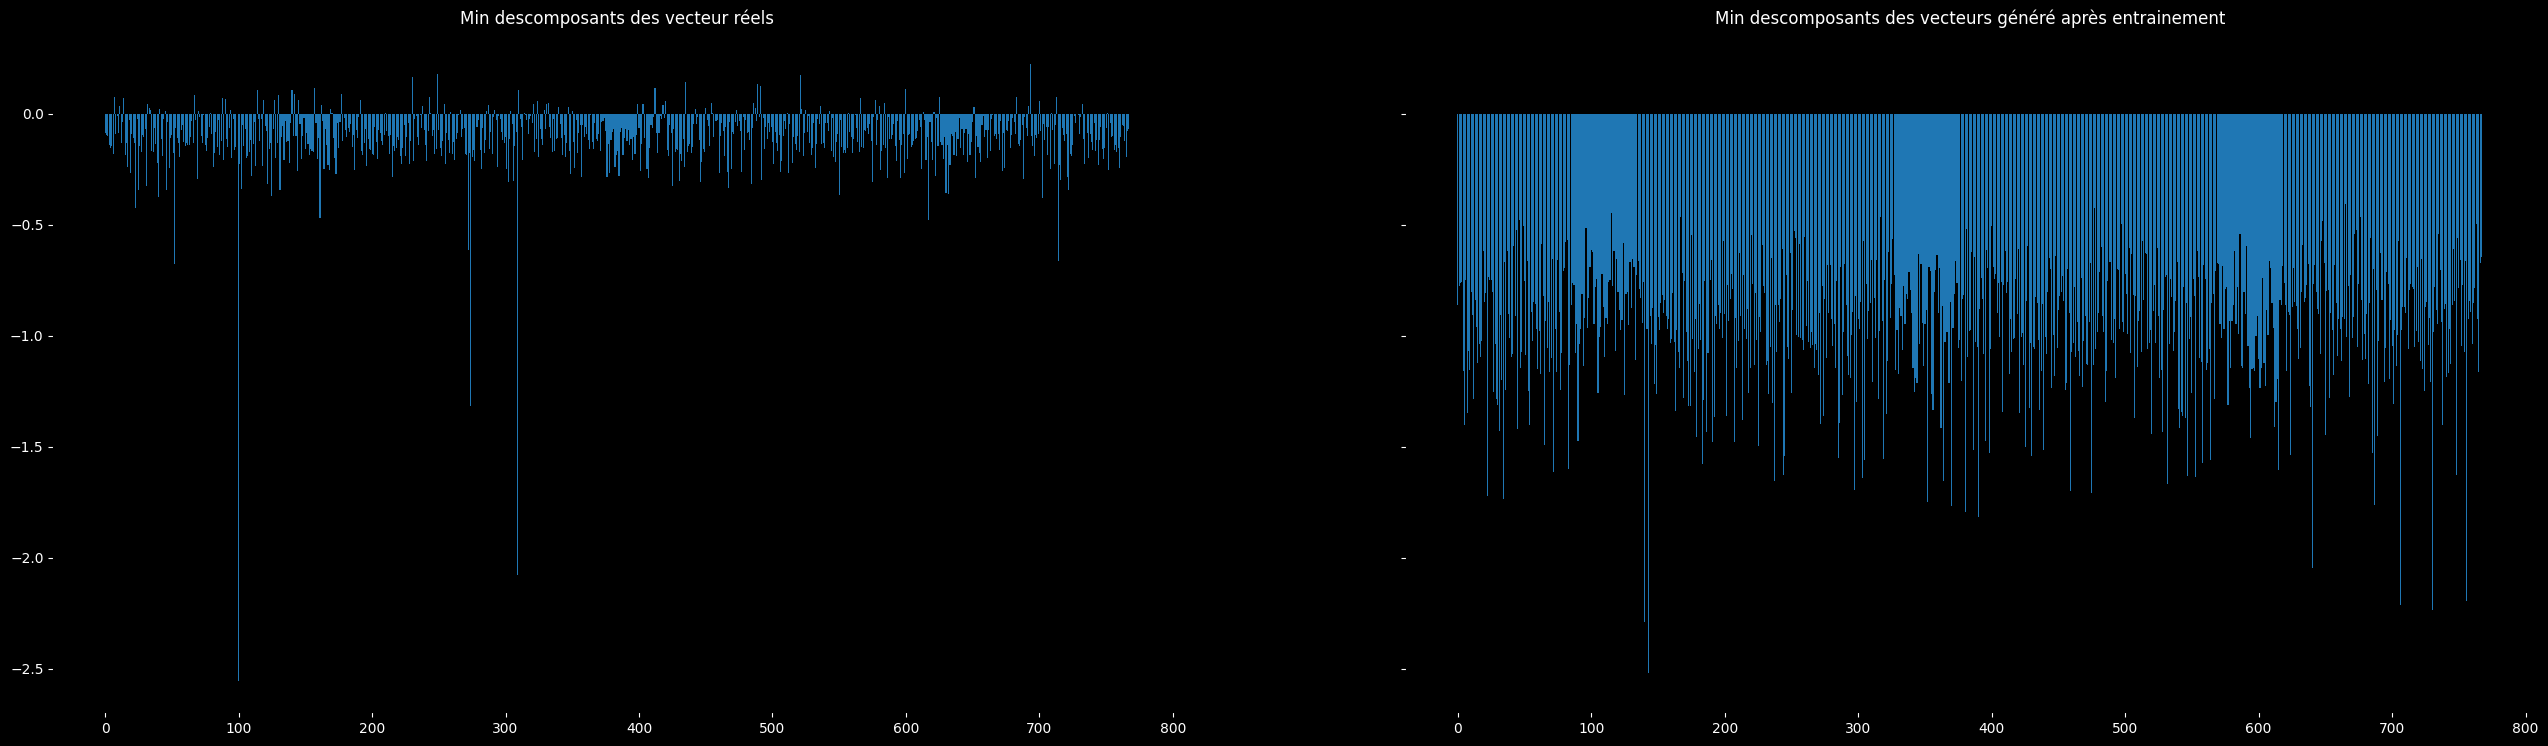

In [23]:
l = np.repeat(1, 100).reshape((-1, 1))
n = generate_noise(100, latent_dim)
w = 16 * 2
h = 9
dpi = 100
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(w, h), dpi=dpi)
pred_apres = G.predict([n, l])

axs[0].bar(range(768), np.mean(sup[:,1:], axis=0))
axs[0].set(title='Moyenne par composants des vecteurs réels')
axs[1].bar(range(768), np.mean(pred_apres, axis=0))
axs[1].set(title='Moyenne par composants des vecteurs généré après entrainement')
plt.show()

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(w, h), dpi=dpi)
axs[0].bar(range(768), np.std(sup[:,1:], axis=0))
axs[0].set(title='Ecart type des vecteurs réels')
axs[1].bar(range(768), np.std(pred_apres, axis=0))
axs[1].set(title='Ecart type des vecteurs généré après entrainement')
plt.show()

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(w, h), dpi=dpi)
axs[0].bar(range(768), np.max(sup[:,1:], axis=0))
axs[0].set(title='Max des composants des vecteurs réels')
axs[1].bar(range(768), np.max(pred_apres, axis=0))
axs[1].set(title='Max des composants des vecteurs généré après entrainement')
plt.show()

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(w, h), dpi=dpi)
axs[0].bar(range(768), np.min(sup[:,1:], axis=0))
axs[0].set(title='Min descomposants des vecteur réels')
axs[1].bar(range(768), np.min(pred_apres, axis=0))
axs[1].set(title='Min descomposants des vecteurs généré après entrainement')
plt.show()

Ancienne evaluation (3 neurones softmax)

In [66]:
histnp = np.asarray(hist)


w, h = 16*2, 9
plt.figure(figsize=(w, h), dpi=80)
plt.plot(histnp[:,[0, 1]])
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 2560x720 with 0 Axes>

IndexError: index 12 is out of bounds for axis 1 with size 2

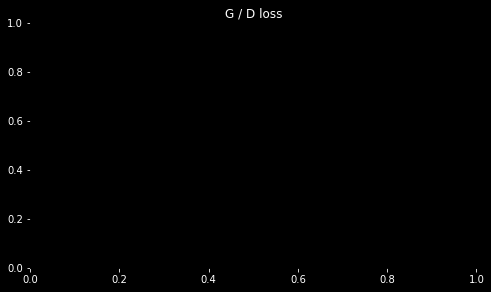

In [410]:
histnp = np.asarray(hist)
w, h = 8, 9/2

plt.figure(figsize=(w, h))
plt.title("G / D loss")
plt.plot(histnp[:,[12, 17]])
plt.show()


plt.figure(figsize=(w, h))
plt.title("G / D ACC label")
plt.plot(histnp[:,[15, 20]])
plt.show()

plt.figure(figsize=(w, h))
plt.title("G / D ACC reality")
plt.plot(histnp[:,[16, 21]])
plt.show()


In [ ]:
histnp = np.asarray(hist)
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

w, h = 8, 9/2
plt.figure(figsize=(w, h))
plt.title("GAN D / G loss")
plt.plot(histnp[:,0:2])
plt.show()

plt.figure(figsize=(w, h))
plt.title("Train / Test LOSS")
plt.plot(histnp[:,[2,2+5]])
plt.show()

plt.figure(figsize=(w, h))
plt.title("Train / Test Label LOSS")
plt.plot(histnp[:,[3,3+5]])
plt.show()

plt.figure(figsize=(w, h))
plt.title("Train / Test Reality LOSS")
plt.plot(histnp[:,[4,4+5]])
plt.show()

plt.figure(figsize=(w, h))
plt.title("Train / Test Label ACC")
plt.plot(histnp[:,[5,5+5]])
plt.show()

plt.figure(figsize=(w, h))
plt.title("Train / Test Reality ACC")
plt.plot(histnp[:,[6,6+5]])
plt.show()


In [64]:
X = np.array(sup_train[:,1:].tolist())
labels = sup_train[:,0]
pred = np.argmax(D(X), axis=1)
display(np.array([labels, pred]).T)
display(D.evaluate(X, labels))

pred_ignore_G = np.argmax(D(X)[:, 0:2], axis=1)
display(np.array([labels, pred_ignore_G]).T)
display(tf.keras.metrics.binary_accuracy(labels, pred_ignore_G).numpy())

C:\Users\Chef\AppData\Local\Temp/ipykernel_7504/1447468073.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  display(np.array([labels, pred]).T)


array([array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]),
       array([[33],
       [33]], dtype=int64)], dtype=object)

2/2 [==============================] - 1s 3ms/step - loss: 0.7125 - Label_loss: 0.5304 - Reality_loss: 0.1821 - Label_acc: 0.5000 - Reality_acc: 0.5000


[0.7125276923179626, 0.5304433703422546, 0.18208426237106323, 0.5, 0.5]

TypeError: list indices must be integers or slices, not tuple

In [65]:
X = np.array(sup_test[:,1:].tolist())
labels = sup_test[:,0]
pred = np.argmax(D(X), axis=1)
display(np.array([labels, pred]).T)
display(D.evaluate(X, labels))

pred_ignore_G = np.argmax(D(X)[:, 0:2], axis=1)
display(np.array([labels, pred_ignore_G]).T)
display(tf.keras.metrics.binary_accuracy(labels, pred_ignore_G).numpy())

C:\Users\Chef\AppData\Local\Temp/ipykernel_7504/3208803584.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  display(np.array([labels, pred]).T)


array([array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]),
       array([[29],
       [29]], dtype=int64)], dtype=object)

2/2 [==============================] - 0s 3ms/step - loss: 0.7113 - Label_loss: 0.5299 - Reality_loss: 0.1814 - Label_acc: 0.5000 - Reality_acc: 0.5000


[0.7112504243850708, 0.5298648476600647, 0.1813855618238449, 0.5, 0.5]

TypeError: list indices must be integers or slices, not tuple

In [ ]:
X, y = generate_fake_samples(10000, 1, G, latent_dim)
pred = np.argmax(D(X), axis=1)
display(np.array([y, pred[np.newaxis].T]).T)
D.evaluate(X, y)
X, y = generate_fake_samples(10000, 0, G, latent_dim)
pred = np.argmax(D(X), axis=1)
display(np.array([y, pred[np.newaxis].T]).T)
D.evaluate(X, y)